In [1]:
import re
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, make_scorer, classification_report, confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, HistGradientBoostingClassifier, BaggingClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeRegressor
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from catboost import CatBoostClassifier

## Data Loading

In [2]:
data_df = pd.read_json('./data/Sarcasm_Headlines_Dataset.json', lines=True)

print(data_df.shape)
data_df.head()

(26709, 3)


,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [3]:
data_df.isnull().sum()

article_link    0
headline        0
is_sarcastic    0
dtype: int64

In [4]:
X = data_df['headline']
y = data_df['is_sarcastic'] 
print(X.shape, y.shape)

(26709,) (26709,)


## Preprocessing

In [5]:
def text_cleaning(text):
    text = re.sub(r"[^A-Za-z0-9']", " ", text) # keep single quote for sarcasm
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r'\b\d+(?:\.\d+)?\s+', '', text)
    text = text.lower()
    return text

In [6]:
count = 0
for i in range(len(X)):
    original_text = X[i]
    cleaned_text = text_cleaning(original_text)
    
    if original_text != cleaned_text:
        print("Original: ", original_text)
        print("Cleaned: ", cleaned_text)
        print("-" * 50)
        count +=1
    if count>=10: break

Original:  the 'roseanne' revival catches up to our thorny political mood, for better and worse
Cleaned:  the 'roseanne' revival catches up to our thorny political mood  for better and worse
--------------------------------------------------
Original:  mom starting to fear son's web series closest thing she will have to grandchild
Cleaned:  mom starting to fear son  web series closest thing she will have to grandchild
--------------------------------------------------
Original:  boehner just wants wife to listen, not come up with alternative debt-reduction ideas
Cleaned:  boehner just wants wife to listen  not come up with alternative debt reduction ideas
--------------------------------------------------
Original:  j.k. rowling wishes snape happy birthday in the most magical way
Cleaned:  j k  rowling wishes snape happy birthday in the most magical way
--------------------------------------------------
Original:  advancing the world's women
Cleaned:  advancing the world  women
-------

## Data Split

Class Distribution: 
 is_sarcastic
0    14985
1    11724
Name: count, dtype: int64


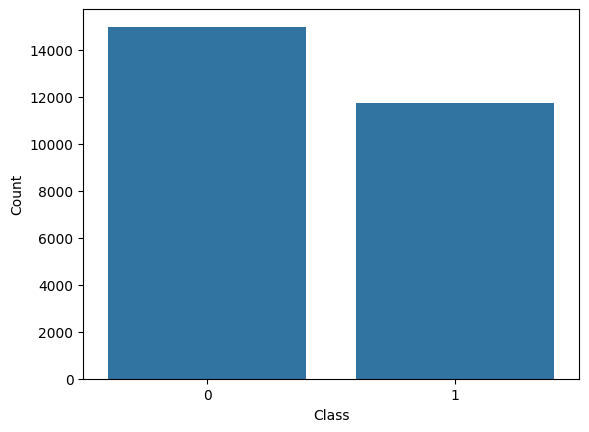

In [7]:
cd = y.value_counts()
print("Class Distribution: \n", cd)

sns.barplot(x=cd.index, y=cd.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [8]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, stratify=y_temp, test_size=0.2, random_state=42)
print(f"Train: {X_train.shape} {X_test.shape} | Test: {X_val.shape} {y_val.shape} | Test: {X_test.shape} {y_test.shape}")

Train: (17093,) (5342,) | Test: (4274,) (4274,) | Test: (5342,) (5342,)


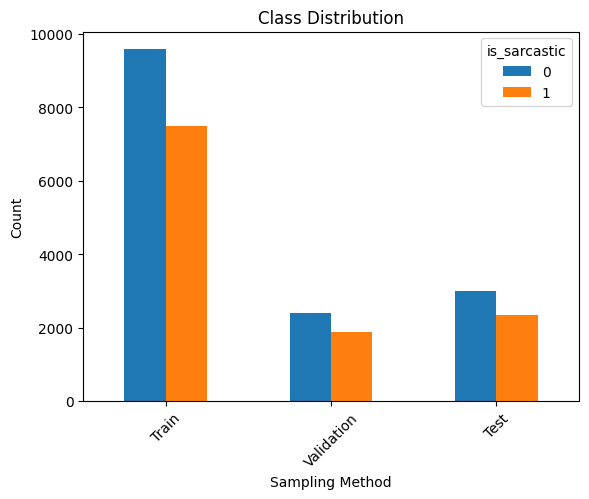

In [9]:
cd_train = y_train.value_counts()
cd_val = y_val.value_counts()
cd_test = y_test.value_counts()

cd_df = pd.DataFrame({
    'Train': cd_train,
    'Validation': cd_val,
    'Test': cd_test,
})

cd_df.T.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Sampling Method')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## Feature Extraction

In [10]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X_train_vectors = vectorizer.fit_transform(X_train)
X_val_vectors = vectorizer.transform(X_val)
X_test_vectors = vectorizer.transform(X_test)

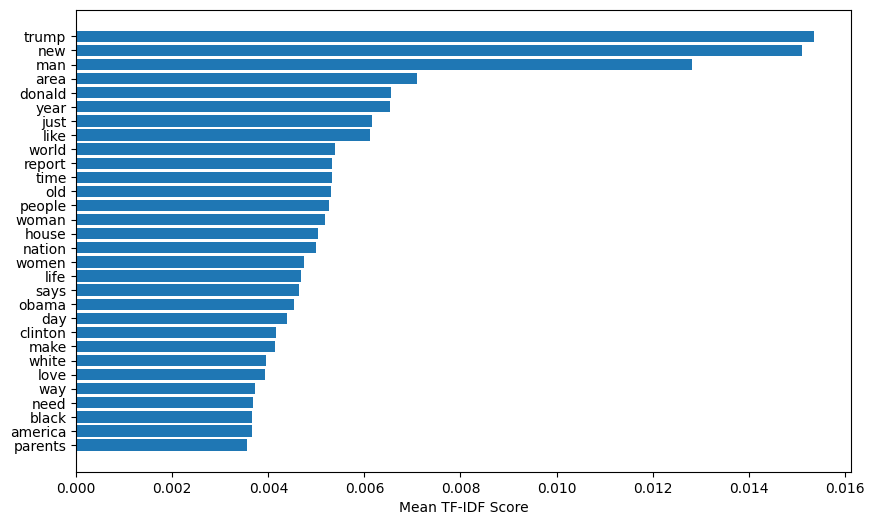

In [11]:
score_df = pd.DataFrame({"word": vectorizer.get_feature_names_out(), "mean_tfidf": X_test_vectors.mean(axis=0).A1})
top_words = score_df.nlargest(30, "mean_tfidf")

plt.figure(figsize=(10, 6))
plt.barh(top_words["word"], top_words["mean_tfidf"], align="center")
plt.gca().invert_yaxis()
plt.xlabel("Mean TF-IDF Score")
plt.show()

## Regressor/Tree-Based Models

In [12]:
tree_models = {
    "Logistic Regressor": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(),
    "LightGBM": LGBMClassifier(verbose=0),
    "Extra Trees": ExtraTreesClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Bagging": BaggingClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0)
}

param_grids = {
    "Logistic Regressor":{
        "penalty": ["l1", "l2"],
        "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        "solver": ["liblinear", "saga"],
        "max_iter": [5000]
    },
    "Decision Tree": {
        "criterion": ["gini", "entropy"],
        "max_depth": [10, 20, 30, 50, None],
        "min_samples_split": [2, 5, 10, 25],
        "min_samples_leaf": [1, 2, 5, 10]
    },
    "Random Forest": {
        "n_estimators": [50, 100, 200, 500],
        "max_depth": [10, 20, 40, None],
        "min_samples_split": [2, 5, 10],
        "max_features": ["sqrt", "log2", None]
    },
    "Gradient Boosting": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.001, 0.005, 0.01, 0.05, 0.1, 1.0],
        "max_depth": [3, 5, 7],
        "subsample": [0.7, 0.8, 1.0]
    },
    "XGBoost": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.001, 0.005, 0.01, 0.05, 0.1, 1.0],
        "max_depth": [3, 5, 7],
        "eval_metric": ["logloss"],
        "colsample_bytree": [0.7, 0.8, 1.0],
        "gamma": [0, 0.1, 0.3, 0.5]
    },
    "LightGBM": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "num_leaves": [20, 31, 40],
        "max_bin": [63, 127, 255],
        "min_child_samples": [10, 20, 30, 50],
        "boosting_type": ["gbdt", "dart"]
    },
    "Extra Trees": {
        "n_estimators": [50, 100, 200],
        "max_depth": [10, 20, None],
        "min_samples_split": [2, 5, 10],
        "max_features": ["sqrt", "log2", None],
        "min_samples_leaf": [1, 2, 5],
        "bootstrap": [True, False]
    },
    "AdaBoost": {
        "n_estimators": [10, 50, 100, 200, 500],
        "learning_rate": [0.001, 0.005, 0.01, 0.05, 0.1, 1.0],
        "algorithm": ["SAMME"],
    },              
    "Bagging": {
        "n_estimators": [10, 25, 50, 100],
        "max_samples": [0.5, 0.7, 0.9, 1.0],
        "max_features": [0.2, 0.5, 0.8, 1.0],
        "bootstrap": [True, False]
    },
    "CatBoost":{
        "iterations": [100, 200, 300],
        "learning_rate": [0.01, 0.1, 0.2],
        "depth": [3, 5, 7],
        "l2_leaf_reg": [1, 3, 5, 10],
        "bagging_temperature": [0, 0.5, 1.0],
        "grow_policy": ["SymmetricTree", "Depthwise", "Lossguide"]
    },
}

In [13]:
tree_results = {}
for model_name, model in tree_models.items():
    print(f"Training {model_name}...")
    
    search = RandomizedSearchCV(
        model,
        param_distributions=param_grids[model_name],
        n_iter=20,
        scoring={
            'f1': make_scorer(f1_score, average='weighted'),
            'accuracy': make_scorer(accuracy_score)
        },
        refit='f1',  
        cv=3,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train_vectors, y_train)
    tree_results[model_name] = {"cv_results": pd.DataFrame(search.cv_results_), "best_estimator": search.best_estimator_}

Training Logistic Regressor...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Training Decision Tree...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Training Random Forest...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Training Gradient Boosting...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Training XGBoost...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Training LightGBM...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Training Extra Trees...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Training AdaBoost...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Training Bagging...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Training CatBoost...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


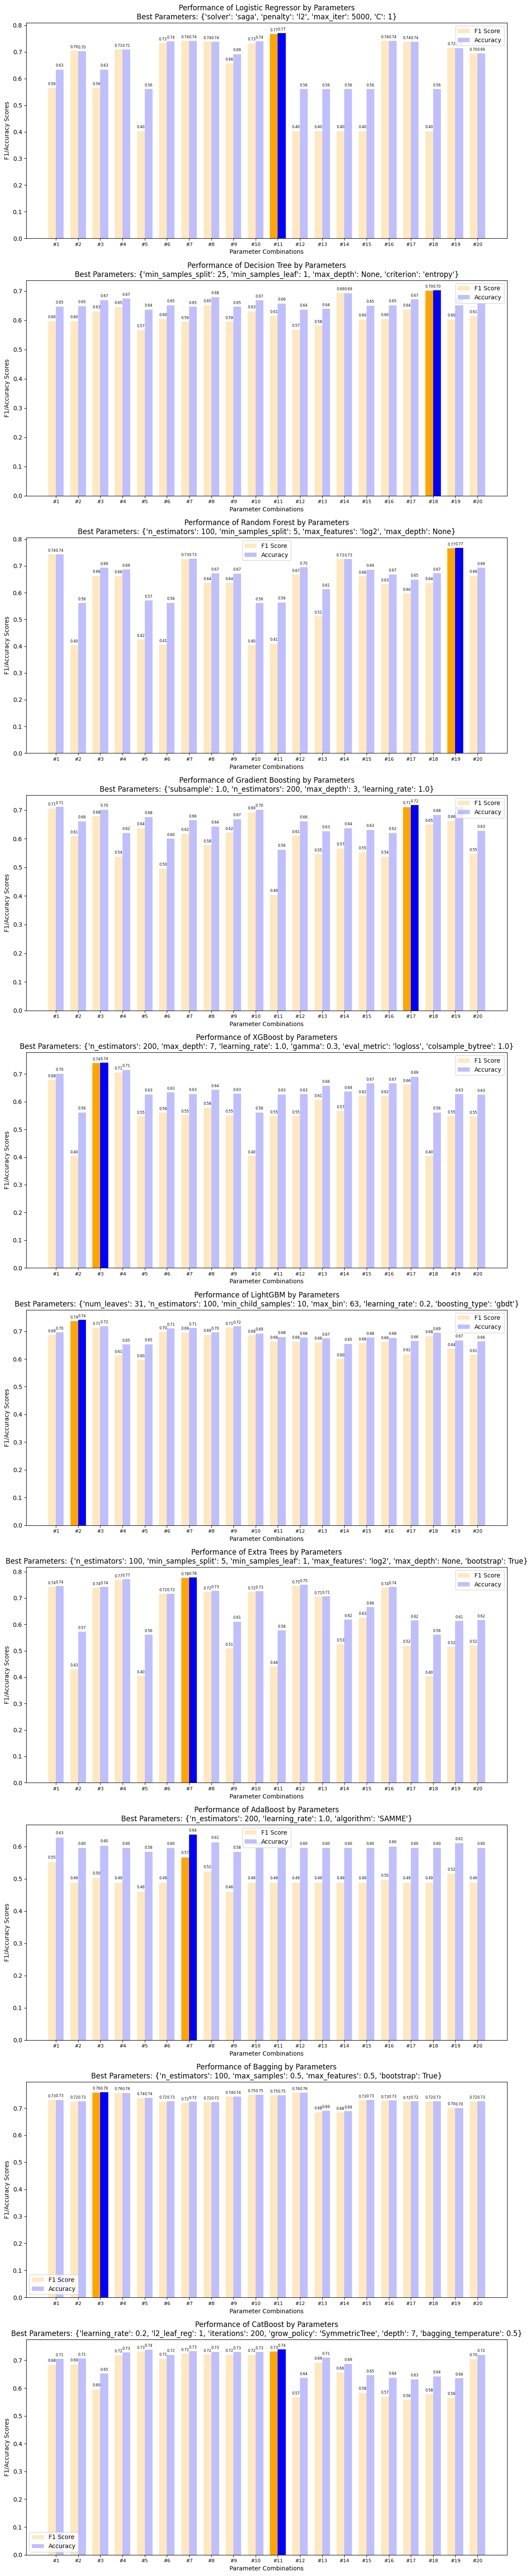

In [15]:
fig, axes = plt.subplots(len(tree_results), 1, figsize=(12, 6 * len(tree_results)))

for ax, (model_name, model_data) in zip(axes, tree_results.items()):
    # Best parameter combination
    best_index = model_data["cv_results"]["rank_test_f1"].idxmin()
  
    # F1 and Accuracy Scores
    f1_scores = model_data["cv_results"]["mean_test_f1"]
    accuracy_scores = model_data["cv_results"]["mean_test_accuracy"]

    for i, f1 in enumerate(f1_scores):
        ax.bar(
            i - 0.35 / 2,
            f1,
            width=0.35,
            color='orange' if i == best_index else 'orange',
            alpha=1.0 if i == best_index else 0.25,
            label='F1 Score' if i == 0 else None
        )
    for i, acc in enumerate(accuracy_scores):
        ax.bar(
            i + 0.35 / 2,
            acc,
            width=0.35,
            color='blue' if i == best_index else 'blue',
            alpha=1.0 if i == best_index else 0.25,
            label='Accuracy' if i == 0 else None
        )

    for i, (f1, acc) in enumerate(zip(f1_scores, accuracy_scores)):
        ax.text(i - 0.35 / 2, f1 + 0.01, f"{f1:.2f}", ha="center", fontsize=6)
        ax.text(i + 0.35 / 2, acc + 0.01, f"{acc:.2f}", ha="center", fontsize=6)

    ax.set_title(f"Performance of {model_name} by Parameters\nBest Parameters: {model_data["cv_results"].loc[best_index, "params"]}")
    ax.set_xlabel("Parameter Combinations")
    ax.set_ylabel("F1/Accuracy Scores")
    ax.set_xticks(range(len(model_data["cv_results"])))
    ax.set_xticklabels([f"#{i+1}" for i in range(len(model_data["cv_results"]))], rotation=0, ha="center", fontsize=8)
    ax.legend()

plt.tight_layout()
plt.show()

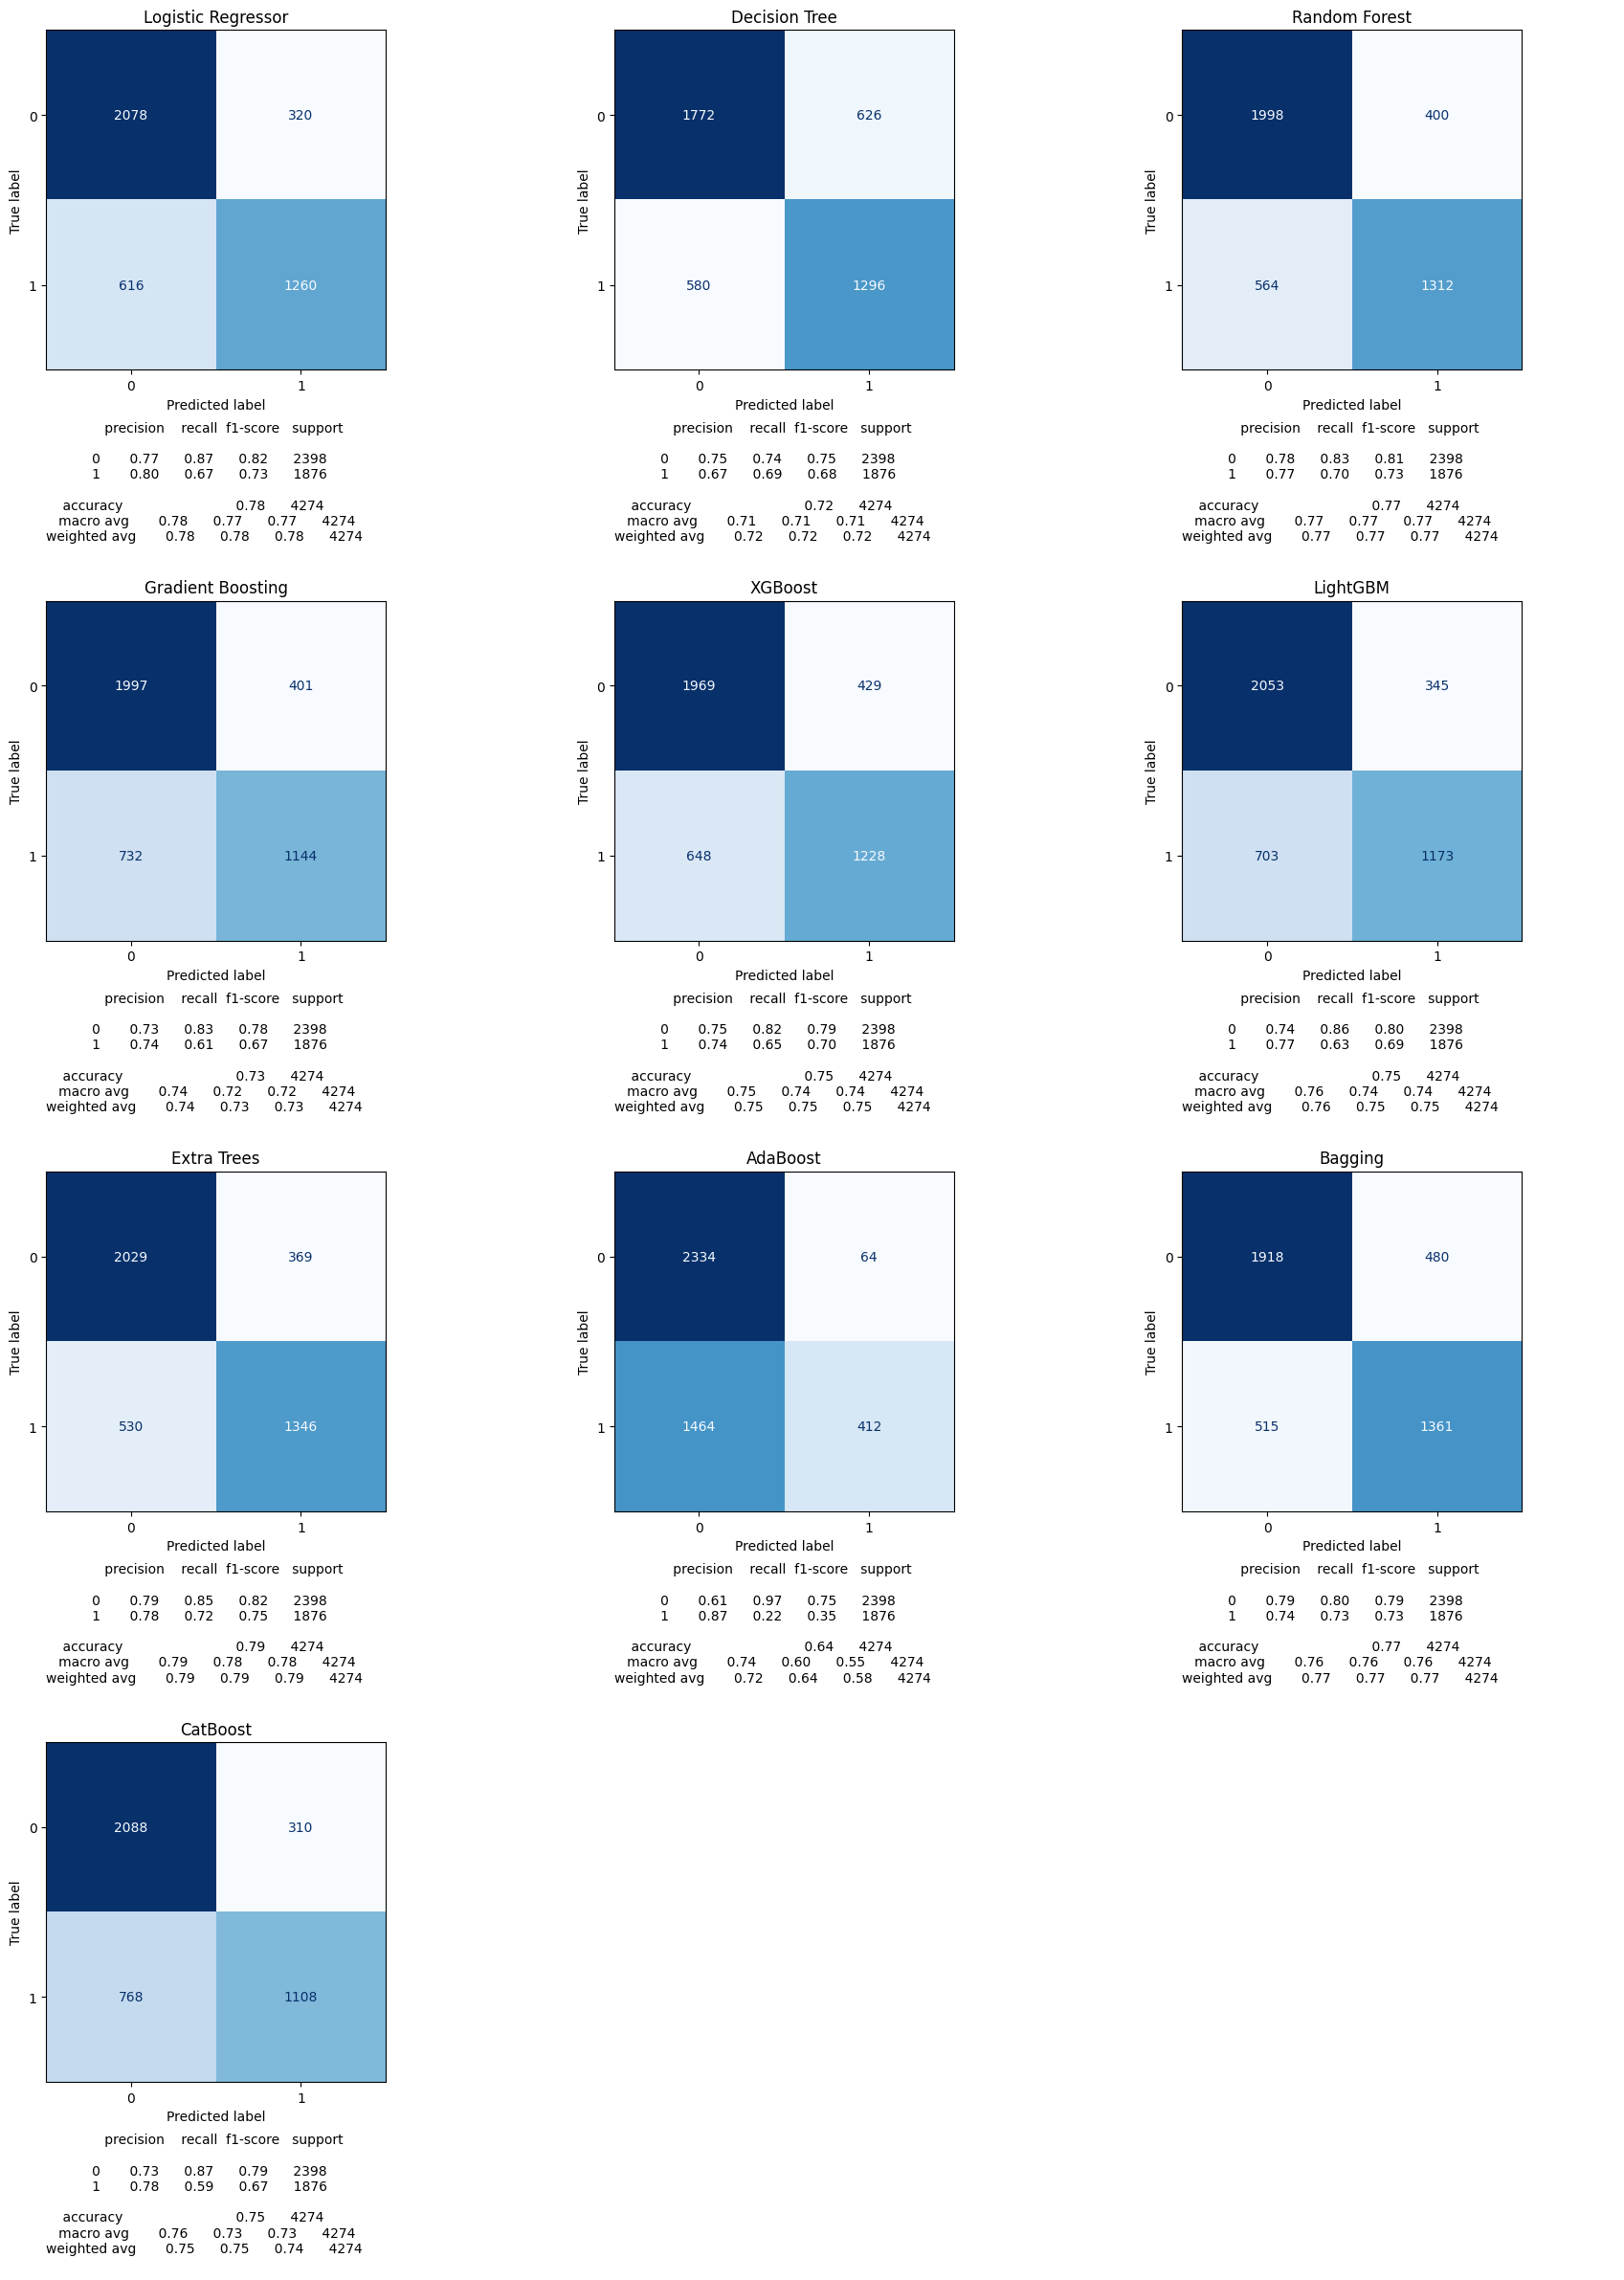

In [16]:
n_rows = math.ceil(len(tree_results) / 3)
fig, axes = plt.subplots(n_rows, 3, figsize=(18, 6 * n_rows))

for ax, (model_name, model_data) in zip(axes.flatten(), tree_results.items()):
    best_model = model_data["best_estimator"]
    y_val_pred = best_model.predict(X_val_vectors)

    # Confusion_matrix
    cm = confusion_matrix(y_val, y_val_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(f"{model_name}")

    # Classification report
    report = classification_report(y_val, y_val_pred)
    ax.text(0.0, -0.15, report, transform=ax.transAxes, fontsize=10, va='top', wrap=True)

# Unused subplots
for ax in axes.flatten()[len(tree_results):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

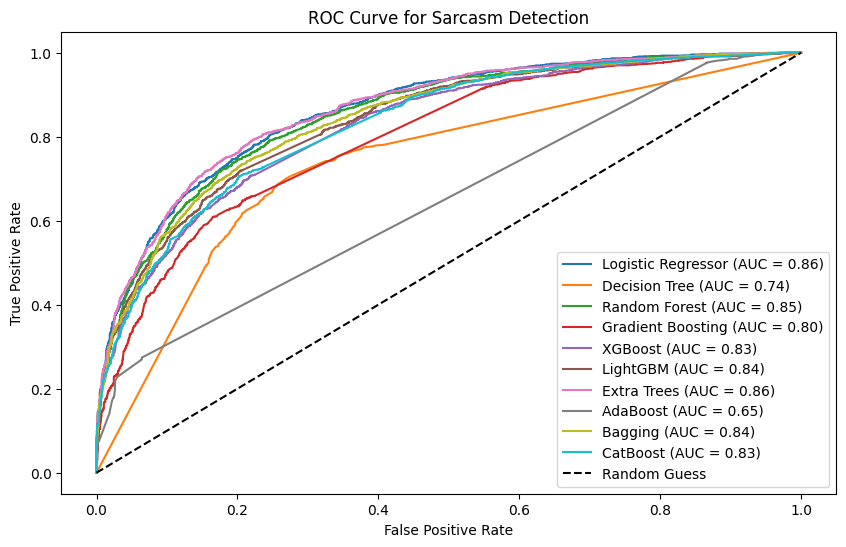

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

for model_name, model_data in tree_results.items():
    best_model = model_data["best_estimator"]

    # Probabilities for is_sarcastic=1
    y_val_proba = best_model.predict_proba(X_val_vectors)[:, 1]

    # ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_val, y_val_proba)
    auc_score = roc_auc_score(y_val, y_val_proba)

    ax.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.2f})")

ax.plot([0, 1], [0, 1], "k--", label="Random Guess") # For reference
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve for Sarcasm Detection")
ax.legend(loc="lower right")
plt.show()